# **General Elections Classifier using Softmax Regression**
---
### Pavlos Dais

# **Prerequisites**

In [1]:
!pip install spacy
!python -m spacy download el_core_news_sm
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 47.7 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import FreqDist
from sklearn.preprocessing import label_binarize
from matplotlib import pyplot as plt
import re
import optuna
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import label_binarize
from itertools import cycle

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

nltk.download("omw")
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('greek'))

# avoid error at data cleaning
pd.options.mode.chained_assignment = None

import spacy
from spacy.lang.el.examples import sentences 

from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nlp = spacy.load("el_core_news_sm")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /usr/share/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Useful Code for Analysis

In [3]:
def show_most_common(data_a, common_words_num):
    # combine all text into a single string
    text = ' '.join(data_a['Text'])

    # generate word frequencies
    word_freq = pd.Series(text.lower().split()).value_counts()

    # plot the most common words
    word_freq.head(common_words_num).plot(kind='bar', rot=45)
    plt.title(f'Top {common_words_num} Most Common Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

# **Useful Code For Data Processing**

In [4]:
# emoji to text functionality
emoji_to_text = {
    "😃": "χαρα",
    "😢": "λυπη",
    "❤️": "καρδια",
    "👍": "συμφωνω",
    "👎": "διαφωνω"
}

# replace these vowels to remove accents
vowel_replacement = {
    'ά':'α',
    'έ':'ε',
    'ή':'η',
    'ί':'ι',
    'ό':'ο',
    'ύ':'υ',
    'ώ':'ω'
}

# my stop words (not included in the nltk library)
my_stop_words = ['ειναι', 'απο', 'οτι', 'μου', 'στις', 'μας', 'της', 'την', 'τον', 'τους', 'τη', 'το', 'στους', 'στα', 'σας', 'αυτο',
                'εχει', 'μια', 'ηταν', 'μια', 'σου', 'ενα', 'αυτος', 'εγω', 'σε', 'ενας', 'ειμαι', 'εχω', 'ο']

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def translate_greek(text):
    translation_table = str.maketrans (
        'abcdefghijklmnopqrstuvwxyz',
        'αβκδεφγηιξκλμνοπθρστυϐωχυζ'
    )
    return text.translate(translation_table)

# preprocesses the tweet
def clean_tweet(tweet_str):
    # convert to lowercase for generalization
    tweet_str = tweet_str.upper()
    tweet_str = tweet_str.lower()
    
    # remove hashtags
    tweet_str = re.sub(r'#\w+', '', tweet_str)
    
    # remove @'s
    tweet_str = re.sub(r'@(\w+)', '', tweet_str)
    
    # remove urls
    tweet_str = re.sub(r'http[s]?://\S+', '', tweet_str)
    
    # remove numbers & special characters
    tweet_str = re.sub(r'[0-9]|\W', ' ', tweet_str)
    
    # remove excess tabs & white spaces
    tweet_str = re.sub(r'\s+', ' ', tweet_str).strip()
    
    # remove stop words
    tweet_str = ' '.join([word for word in tweet_str.split(' ') if word not in stop_words])
    
    # translate english text
    tweet_str = translate_greek(tweet_str)
    
    # replace some emojies with a corresponding text and remove the rest
    for old_vowel, new_vowel in emoji_to_text.items():
        tweet_str = tweet_str.replace(old_vowel, new_vowel)
    tweet_str = re.sub(r'[\U00010000-\U0010ffff]', '', tweet_str)
    
    # run the lemmatization
    tweet_str = lemmatize_text(tweet_str)
    
    # remove accents
    for old_vowel, new_vowel in vowel_replacement.items(): tweet_str = tweet_str.replace(old_vowel, new_vowel)
    
    # remove my stop words
    tweet_str = ' '.join([word for word in tweet_str.split(' ') if word not in my_stop_words])
    
    return tweet_str

def clean_data(text):
    return text.applymap(clean_tweet)

def print_data(text, rows):
    for i in range(rows):
        print(text.iloc[i])

def append_word(cell_value):
    return cell_value + new_word
        
def get_data(data):        
    # extract the important piece of info
    X = data[['Text']]
    Y = data[['Sentiment']]
    parties = data[['Party']]

    clean_X = clean_data(X)
    
    # add political party at the start of the tweet
    for i in range(len(clean_X)):
        political_party = parties.loc[i, 'Party']
        clean_X.loc[i, 'Text'] = str(political_party) + ' ' + clean_X.loc[i, 'Text']
    
    return clean_X, Y

def get_test_data(data):        
    # extract the important piece of info
    X = data[['Text']]
    parties = data[['Party']]

    clean_X = clean_data(X)
    
    # add political party at the start of the tweet
    for i in range(len(clean_X)):
        political_party = parties.loc[i, 'Party']
        clean_X.loc[i, 'Text'] = str(political_party) + ' ' + clean_X.loc[i, 'Text']
    
    return clean_X
    

# convert dataframe to numpy array
def conv_nump(X):
    return (X[0].to_numpy(), X[1].to_numpy())

# **Data Processing**

Before processing:


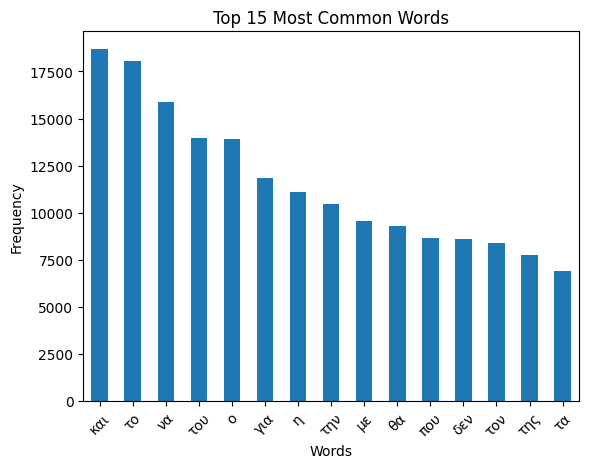

After processing:


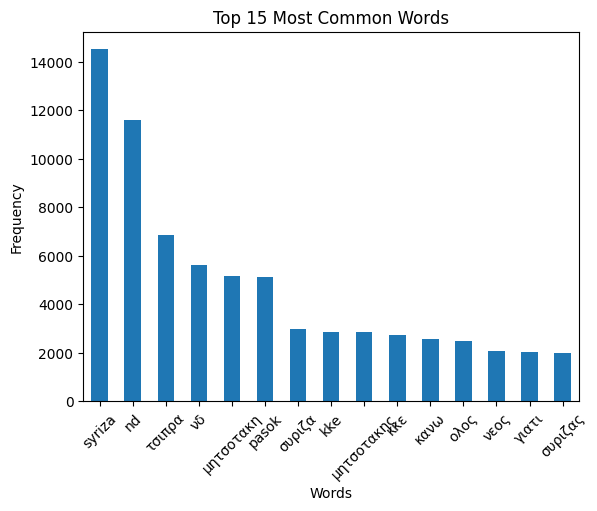

In [5]:
# read the dataframes
train_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-1/train_set.csv")
test_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-1/valid_set.csv")

# plot this many words
common_words_num = 15

print("Before processing:")
show_most_common(train_df, common_words_num)

# convert it
train_data = get_data(train_df)
test_data = get_data(test_df)

print("After processing:")
show_most_common(train_data[0], common_words_num)

conv_train_data = conv_nump(train_data)
conv_test_data = conv_nump(test_data)

# **Useful Code For Training**

In [6]:
def flatten_data(data):
    return [item for sublist in data for item in sublist]

def create_division_list(num1, num2):
    return [ int(num1 / num2 * i) for i in range(1, num2 + 1)]

# train the model
def plot_results(model, vectorizer, train_data, test_data, training_sizes, train_scores, val_scores, label):
    # make the model 1d
    X_train, Y_train = train_data
    X_value, Y_value = test_data
    flattened_x = flatten_data(X_train)
    flattened_y = flatten_data(Y_train)
    flattened_x_val = flatten_data(X_value)
    flattened_y_val = flatten_data(Y_value)
    
    # vectorize & train data
    vec_train = vectorizer.fit_transform(flattened_x)
    model.fit(vec_train, flattened_y)
    
    temp_x_val = vectorizer.transform(flattened_x_val)
    validation_pred = model.predict(temp_x_val)
    
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
    class_labels = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    
    # calculate confusion matrix
    cm = confusion_matrix(flattened_y_val, validation_pred, labels=class_labels)
    train_pred = model.predict_proba(temp_x_val)

    # calculate ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    true_labels_bin = label_binarize(flattened_y_val, classes=class_labels)
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], [score[i] for score in train_pred])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # create a single figure with subplots for confusion matrix and ROC curve
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # confusion matrix plot
    disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
    disp.plot(include_values=True, cmap="viridis", ax=axes[0], xticks_rotation="vertical")
    axes[0].set_title("Confusion matrix")

    # ROC curve plot
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(class_labels)), colors):
        axes[1].plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
    axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('(ROC) Curve')
    axes[1].legend(loc='lower right')
    
    # learning rate plot
    axes[2].scatter(training_sizes, train_scores, color = 'red', label = "Training score")
    axes[2].scatter(training_sizes, val_scores, color = 'blue', label = "Validation score")
    axes[2].plot(training_sizes, train_scores, 'r-')
    axes[2].plot(training_sizes, val_scores, 'b-')
    axes[2].set_title('Learning Rate')
    axes[2].set_xlabel('Training examples')
    axes[2].set_ylabel('F1 score')
    axes[2].legend()
    
    fig.suptitle(label, fontsize=16)
    plt.tight_layout()
    plt.show()

# train the model and print the scores
# confusion matrix, ROC curve & learning rate
def train_and_print_model(model, vectorizer, training_sizes, train_data, test_data, label):
    # save the train scores
    train_scores = list()
    val_scores = list()

    # get data
    X_train, Y_train = train_data
    X_value, Y_value = test_data
    flattened_x = flatten_data(X_train)
    flattened_y = flatten_data(Y_train)
    flattened_x_val = flatten_data(X_value)
    flattened_y_val = flatten_data(Y_value)
    
    # iterate through the train size array
    for size in training_sizes:
        
        # take a sub of the array
        train_sub = flattened_x[:size]
        train_res = flattened_y[:size]
        
        vec_train = vectorizer.fit_transform(train_sub)
        
        # train model
        model.fit(vec_train, train_res)

        temp_x_val = vectorizer.transform(flattened_x_val)
        
        # make predictions
        train_pred = model.predict(vec_train)
        validation_pred = model.predict(temp_x_val)
        
        # add scores to our list
        train_scores.append(f1_score(train_res, train_pred, average='weighted'))
        val_scores.append(f1_score(Y_value, validation_pred, average='weighted'))            
    
    plot_results(model,vectorizer, train_data, test_data, training_sizes, train_scores, val_scores, label)
    print(f"Final train score = {train_scores[len(train_scores)-1]}")
    print(f"Final val score = {val_scores[len(val_scores)-1]}")

# **Picking vectorizers**
Here, I experiment with different vectorizers such as Count Vectorization, Hashing & TF-IDF. I conclude that TF-IDF gives the best results when it comes to overfitting and overall performance.


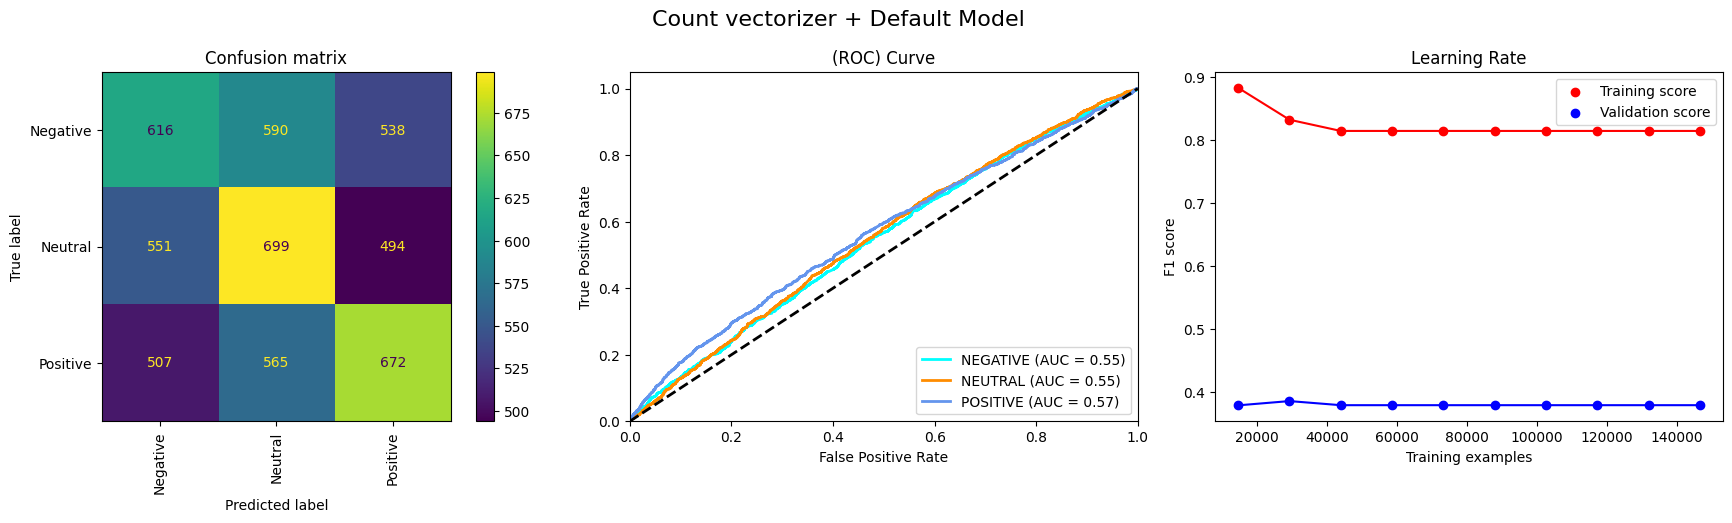

Final train score = 0.8143580074049894
Final val score = 0.3795950272656291


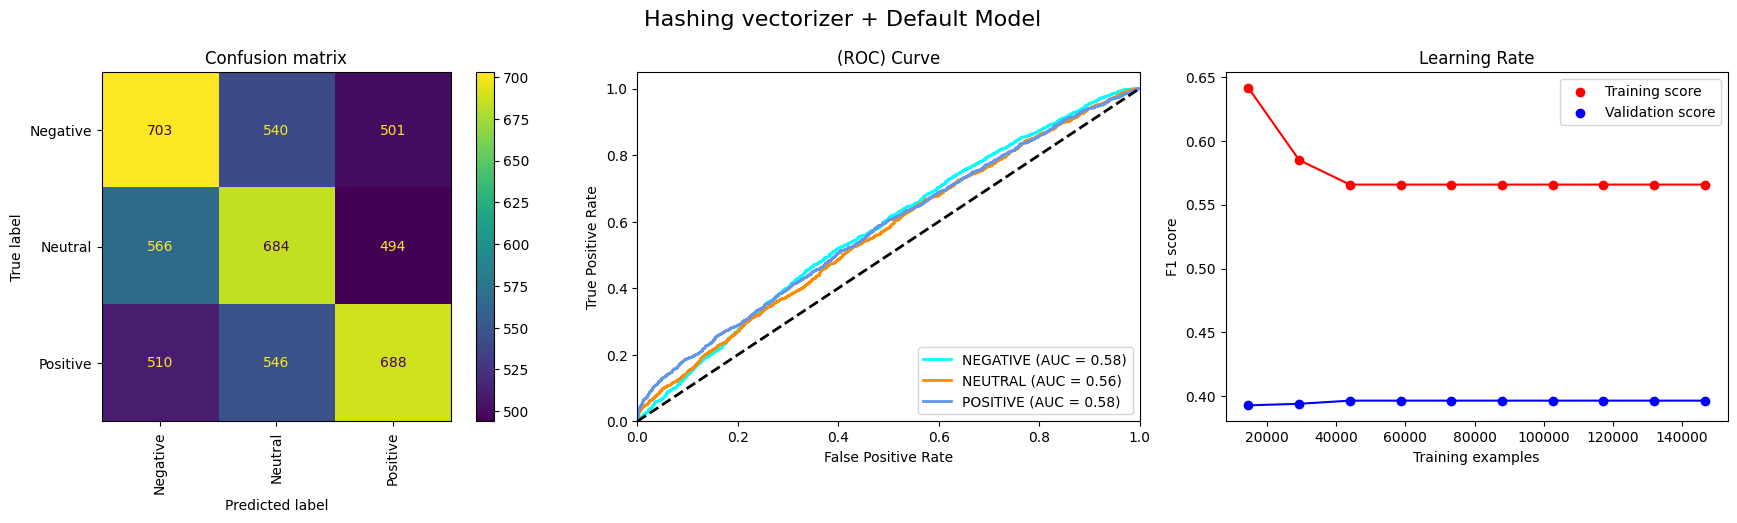

Final train score = 0.5656675267394924
Final val score = 0.39663632947787836


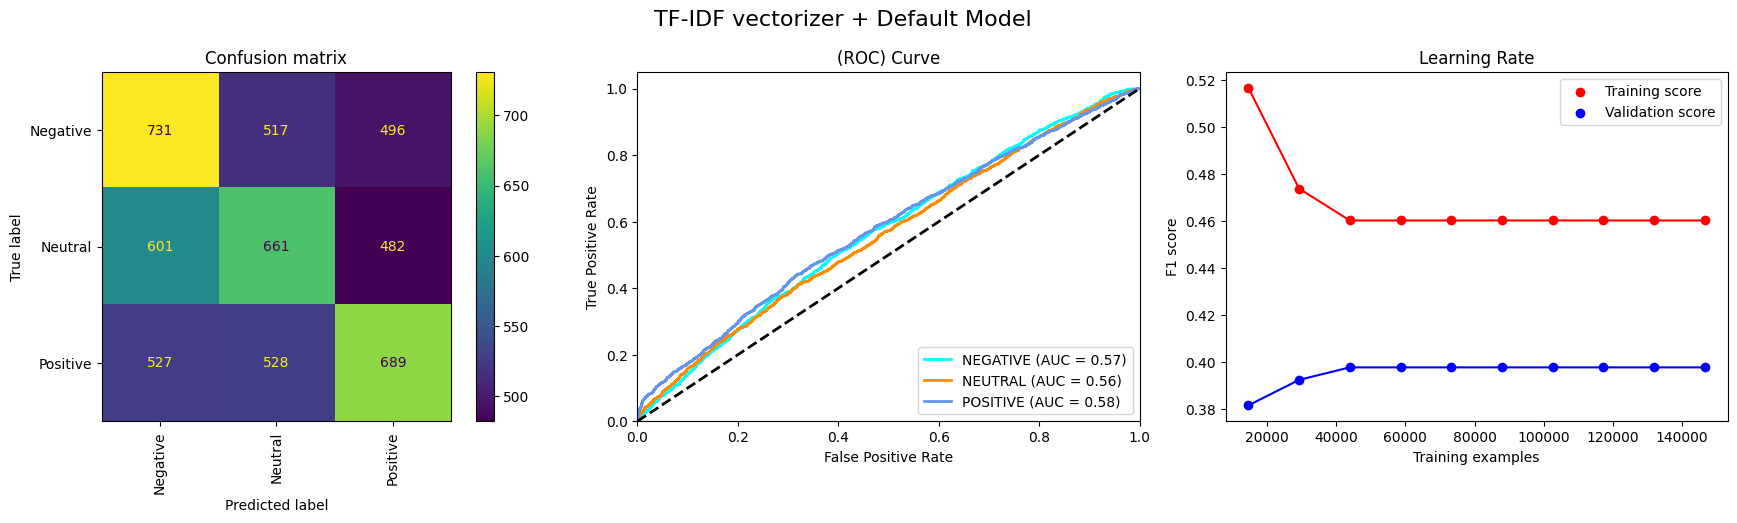

Final train score = 0.46026670271605336
Final val score = 0.39764949110869685


In [7]:
# experimenting with different vectorizers
# 1. Count   Vectorizer
# 2. Hashing Vectorizer
# 3. TF-IDF  Vectorizer

vectorizer_c = CountVectorizer()
vectorizer_h = HashingVectorizer(n_features=10000)
vectorizer_t = TfidfVectorizer(max_df=0.90, min_df=0.001, ngram_range=(1,1))

# use a model, with no hypertuning optimization, to test it
default_model = LogisticRegression(max_iter=10000, multi_class='multinomial')

# print the scores
train_and_print_model(default_model, vectorizer_c, create_division_list(train_df.size, 10), conv_train_data, conv_test_data, "Count vectorizer + Default Model")
train_and_print_model(default_model, vectorizer_h, create_division_list(train_df.size, 10), conv_train_data, conv_test_data, "Hashing vectorizer + Default Model")
train_and_print_model(default_model, vectorizer_t, create_division_list(train_df.size, 10), conv_train_data, conv_test_data, "TF-IDF vectorizer + Default Model")

# **Picking models**
Here, I experiment with different models using my own hyperparameters.

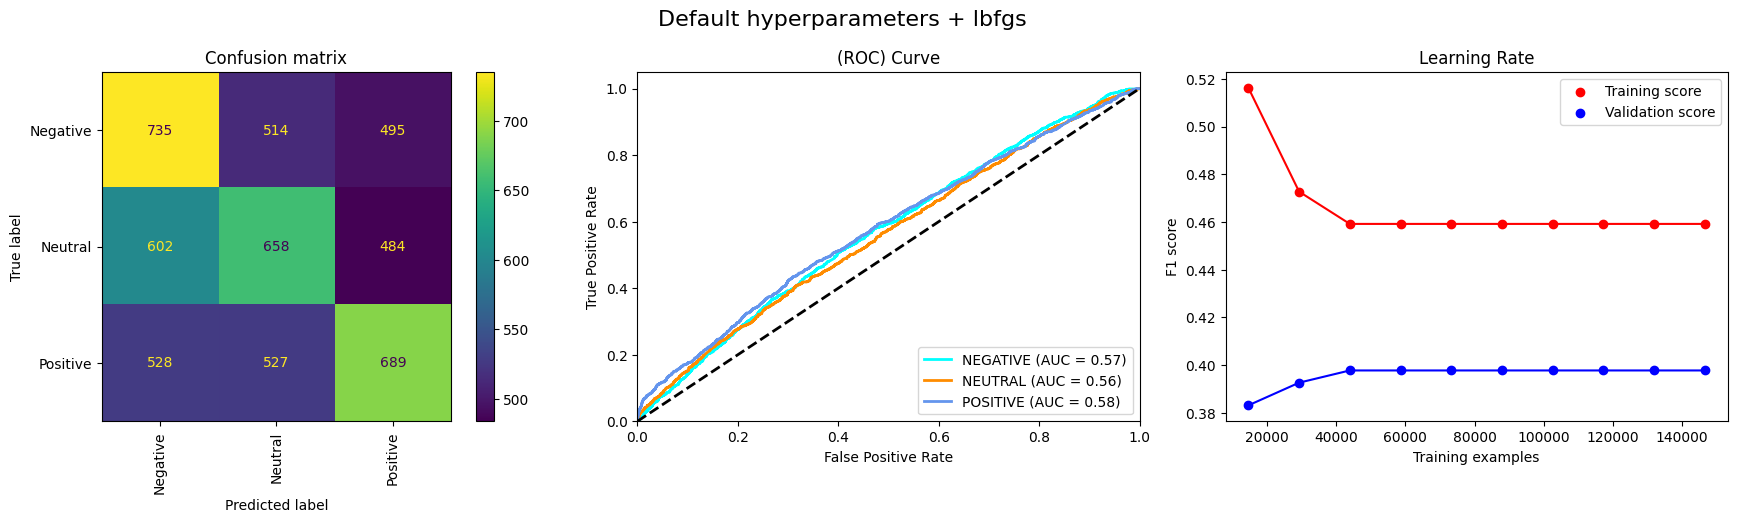

Final train score = 0.4591916828351489
Final val score = 0.3978028494598377


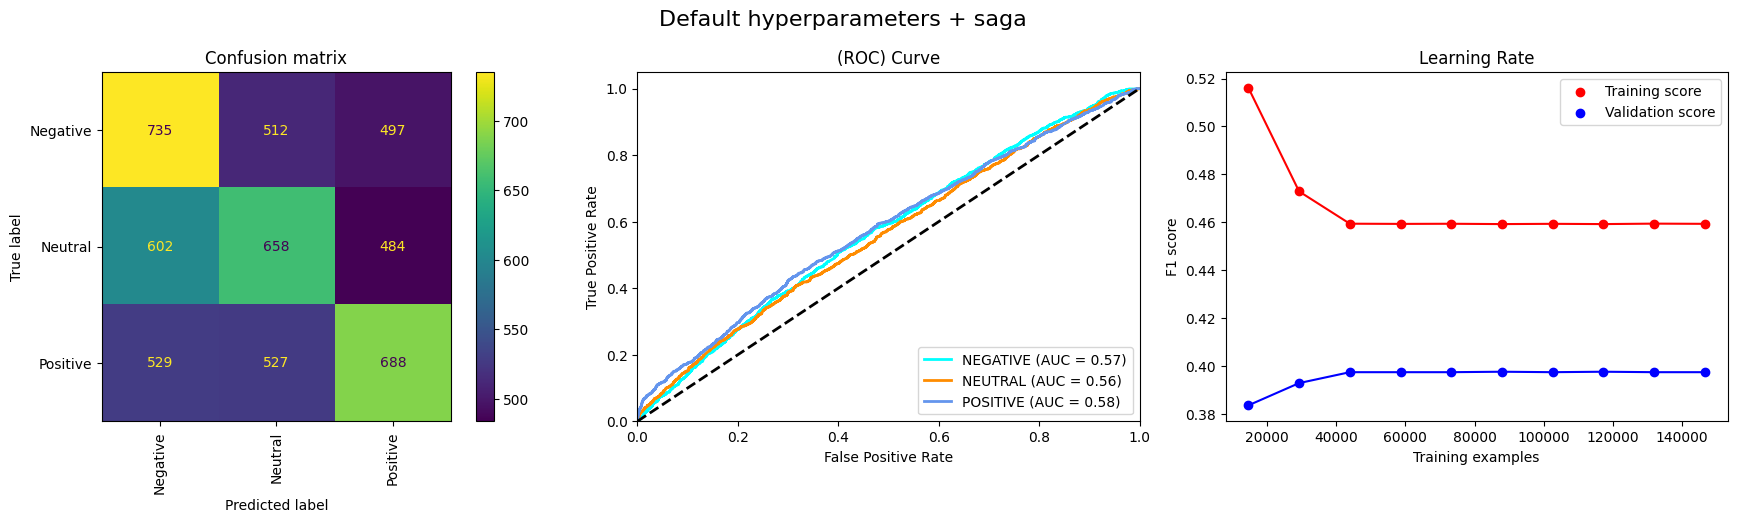

Final train score = 0.45935315913996105
Final val score = 0.3974138146463763


In [8]:
# we have concluded that TF-IDF is performing the best, use it as a default vectorizer
default_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df=0.95, min_df=0.001)

# use a model with default hyperameters
model_l = LogisticRegression(penalty='l2', C=0.8, max_iter=20000, multi_class='multinomial', solver='lbfgs')
model_s = LogisticRegression(penalty='l2', C=0.8, max_iter=20000, multi_class='multinomial', solver='saga')

# print the scores
train_and_print_model(model_l, default_vectorizer, create_division_list(train_df.size, 10), conv_train_data, conv_test_data, "Default hyperparameters + lbfgs")
train_and_print_model(model_s, default_vectorizer, create_division_list(train_df.size, 10), conv_train_data, conv_test_data, "Default hyperparameters + saga")

# **Running optimization**
Finally, i'll be using the optuna framework for hyperparameter optimization.

In [9]:
# get data
trainn_x, trainn_y = conv_train_data

flattened_x = flatten_data(trainn_x)
flattened_y = flatten_data(trainn_y)

vall_x, vall_y = conv_test_data
flattened_x_val = flatten_data(vall_x)
flattened_y_val =  flatten_data(vall_y)

# define range
max_df_range = min_df_range = C_range = None

def objective(trial):
    max_df = trial.suggest_float('max_df', max_df_range[0], max_df_range[1])
    min_df = trial.suggest_float('min_df', min_df_range[0], min_df_range[1])
    max_iter = trial.suggest_int('max_iter', 20000, 20000)
    C = trial.suggest_float('C', C_range[0], C_range[1])
    
    # create vectorizer
    vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df=max_df, min_df=min_df)

    # fit and transform the training data
    X_train_tfidf = vectorizer.fit_transform(flattened_x)

    # create and train the model
    model = LogisticRegression(penalty='l2', C=C, max_iter=max_iter, multi_class='multinomial', solver='lbfgs')
    model.fit(X_train_tfidf, flattened_y)

    # transform the test data and predict
    X_test_tfidf = vectorizer.transform(flattened_x)
    y_pred = model.predict(X_test_tfidf)

    # calculate the F1 score
    return f1_score(flattened_y, y_pred, average='weighted')

# run optuna with 100 trials
def run_optuna():
    study = optuna.create_study(direction='maximize')
    
    # start optimization
    study.optimize(objective, n_trials=100)

    # return the best hyperparameters and best score
    return [study.best_params, study.best_value]

# **Optuna 1**

[I 2023-11-23 13:24:57,785] A new study created in memory with name: no-name-4f9e5155-5ede-43ad-919b-ed8be3023bf4
[I 2023-11-23 13:25:01,157] Trial 0 finished with value: 0.445957880063684 and parameters: {'max_df': 0.8199190450196137, 'min_df': 0.0012764491184656924, 'max_iter': 20000, 'C': 0.28309616035543794}. Best is trial 0 with value: 0.445957880063684.
[I 2023-11-23 13:25:03,514] Trial 1 finished with value: 0.4120885509393288 and parameters: {'max_df': 0.9240471036603835, 'min_df': 0.0010624538937426572, 'max_iter': 20000, 'C': 0.01451847066571629}. Best is trial 0 with value: 0.445957880063684.
[I 2023-11-23 13:25:06,376] Trial 2 finished with value: 0.455572142000686 and parameters: {'max_df': 0.8824728341718396, 'min_df': 0.0008636600187588116, 'max_iter': 20000, 'C': 0.1415527030181746}. Best is trial 2 with value: 0.455572142000686.
[I 2023-11-23 13:25:09,661] Trial 3 finished with value: 0.45572703215452026 and parameters: {'max_df': 0.9386387570180783, 'min_df': 0.000964

Found model with 0.46442483530375556 fscore


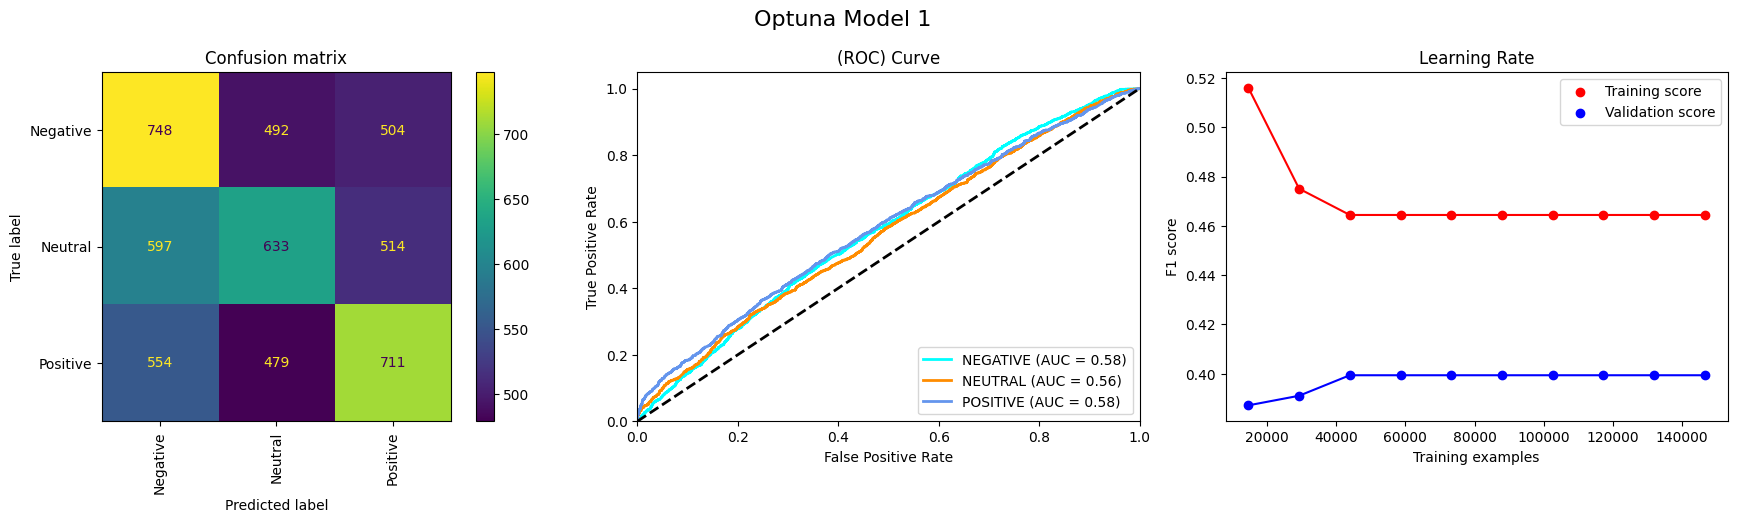

Final train score = 0.46442483530375556
Final val score = 0.3994103493067176
{'max_df': 0.9094562382416433, 'min_df': 0.0008189264733250145, 'max_iter': 20000, 'C': 0.28153933317923735}


In [10]:
# starting off with a relatively large range
max_df_range = [0.8, 0.95]
min_df_range = [0.0008, 0.0015]
C_range = [0.01, 0.3]

parameters, best_val = run_optuna()

print(f"Found model with {best_val} fscore")

opt_model      = LogisticRegression(penalty='l2', C=parameters['C'], max_iter=parameters['max_iter'], multi_class='multinomial', solver='lbfgs')
opt_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df=parameters['max_df'], min_df=parameters['min_df'])
train_and_print_model(opt_model, opt_vectorizer, create_division_list(train_df.size, 10), conv_train_data, conv_test_data, "Optuna Model 1")

print(parameters)

# **Optuna 2**

[I 2023-11-23 13:30:50,056] A new study created in memory with name: no-name-836381b4-c934-4e97-8f9c-b792b8ebd21f
[I 2023-11-23 13:30:52,952] Trial 0 finished with value: 0.4241994483672521 and parameters: {'max_df': 0.9369441382044543, 'min_df': 0.0025557135629557656, 'max_iter': 20000, 'C': 0.23459353880437184}. Best is trial 0 with value: 0.4241994483672521.
[I 2023-11-23 13:30:55,676] Trial 1 finished with value: 0.4136130190229075 and parameters: {'max_df': 0.9312118868555836, 'min_df': 0.0036696351804622277, 'max_iter': 20000, 'C': 0.1399606857140816}. Best is trial 0 with value: 0.4241994483672521.
[I 2023-11-23 13:30:58,079] Trial 2 finished with value: 0.3935970322348379 and parameters: {'max_df': 0.9397525331540308, 'min_df': 0.008452752842758635, 'max_iter': 20000, 'C': 0.04664072641409148}. Best is trial 0 with value: 0.4241994483672521.
[I 2023-11-23 13:31:00,880] Trial 3 finished with value: 0.4151176931523469 and parameters: {'max_df': 0.9343659331969297, 'min_df': 0.003

Found model with 0.4643819517032035 fscore


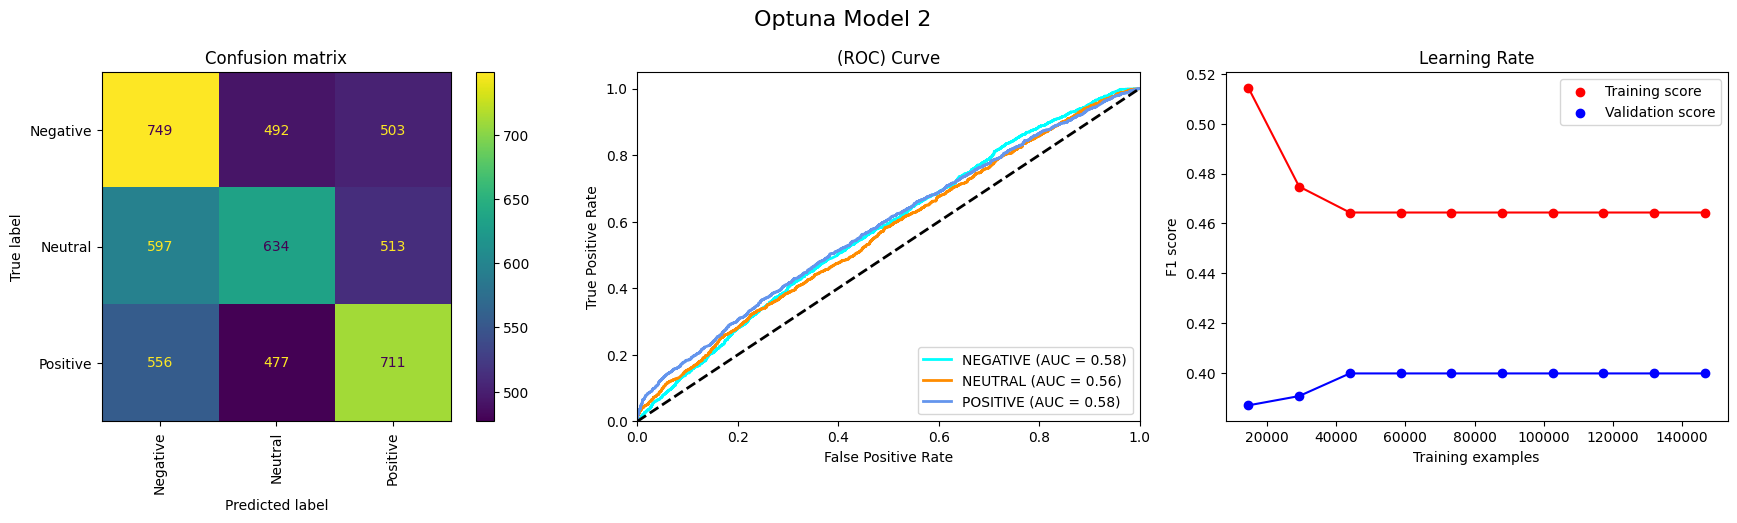

Final train score = 0.4643819517032035
Final val score = 0.3997960512064742
{'max_df': 0.932595058132543, 'min_df': 0.0008106124777237161, 'max_iter': 20000, 'C': 0.2703818464488493}


In [11]:
# taking the results from the previous run, we will be tweaking the parameters a bit to search near that area
max_df_range = [0.93, 0.94]
min_df_range = [0.0008, 0.0085]
C_range = [0.026, 0.28]

parameters, best_val = run_optuna()

print(f"Found model with {best_val} fscore")

opt_model      = LogisticRegression(penalty='l2', C=parameters['C'], max_iter=parameters['max_iter'], multi_class='multinomial', solver='lbfgs')
opt_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df=parameters['max_df'], min_df=parameters['min_df'])
train_and_print_model(opt_model, opt_vectorizer, create_division_list(train_df.size, 10), conv_train_data, conv_test_data, "Optuna Model 2")

print(parameters)

# **Optuna 3**

[I 2023-11-23 13:36:24,074] A new study created in memory with name: no-name-47ca07da-e098-47c0-968a-d75209affded
[I 2023-11-23 13:36:26,812] Trial 0 finished with value: 0.4531867452544749 and parameters: {'max_df': 0.9384881242925496, 'min_df': 0.0007729150923848699, 'max_iter': 20000, 'C': 0.09235033740101327}. Best is trial 0 with value: 0.4531867452544749.
[I 2023-11-23 13:36:29,914] Trial 1 finished with value: 0.4647444304364189 and parameters: {'max_df': 0.937289683599463, 'min_df': 0.0007907918510088286, 'max_iter': 20000, 'C': 0.25304758860468407}. Best is trial 1 with value: 0.4647444304364189.
[I 2023-11-23 13:36:32,473] Trial 2 finished with value: 0.44408629252945425 and parameters: {'max_df': 0.9406162709384257, 'min_df': 0.0008043469096405408, 'max_iter': 20000, 'C': 0.06579508725045422}. Best is trial 1 with value: 0.4647444304364189.
[I 2023-11-23 13:36:35,188] Trial 3 finished with value: 0.45675230307554066 and parameters: {'max_df': 0.9359709351131751, 'min_df': 0.

Found model with 0.4654513098482616 fscore


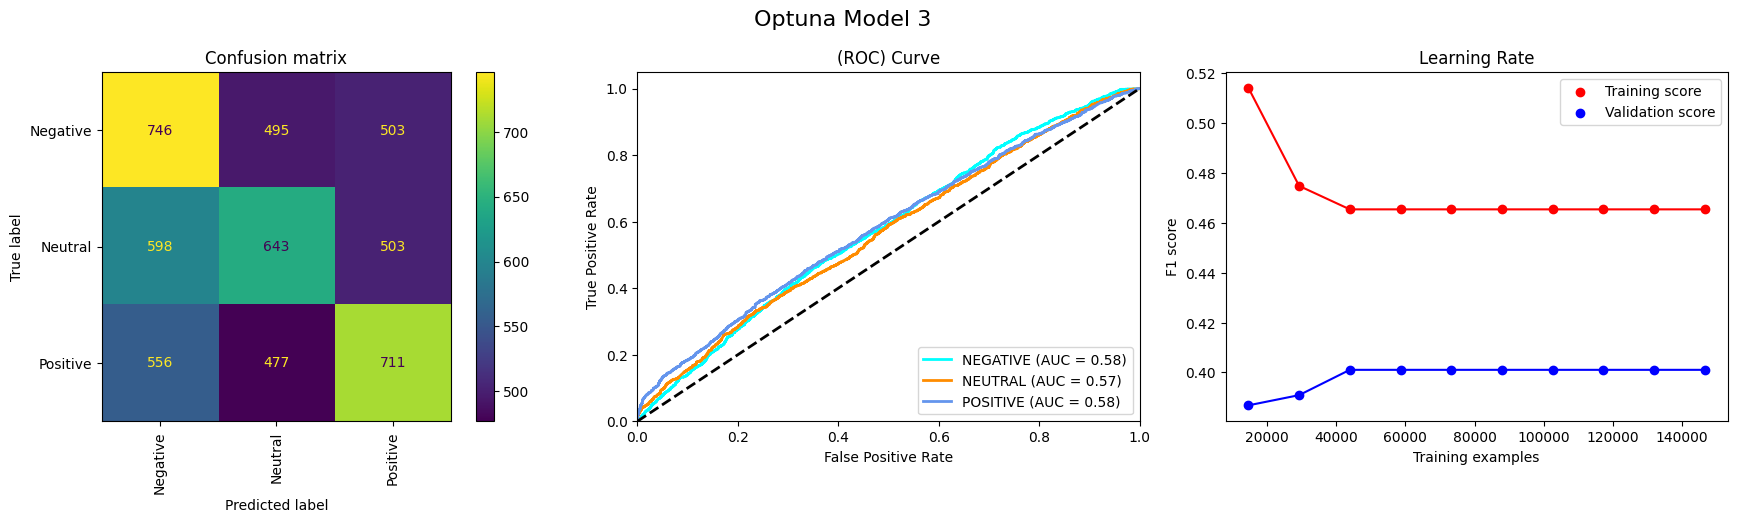

Final train score = 0.4654513098482616
Final val score = 0.401052042364233
{'max_df': 0.9371993584242808, 'min_df': 0.0007856306694761479, 'max_iter': 20000, 'C': 0.26966560947902496}


In [12]:
# finally, we'll run a narrow search near the previously found range
max_df_range = [0.934, 0.942]
min_df_range = [0.00077, 0.00081]
C_range = [0.0255, 0.27]

parameters, best_val = run_optuna()

print(f"Found model with {best_val} fscore")

opt_model      = LogisticRegression(penalty='l2', C=parameters['C'], max_iter=parameters['max_iter'], multi_class='multinomial', solver='lbfgs')
opt_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df=parameters['max_df'], min_df=parameters['min_df'])
train_and_print_model(opt_model, opt_vectorizer, create_division_list(train_df.size, 10), conv_train_data, conv_test_data, "Optuna Model 3")

print(parameters)

# **Final Model**

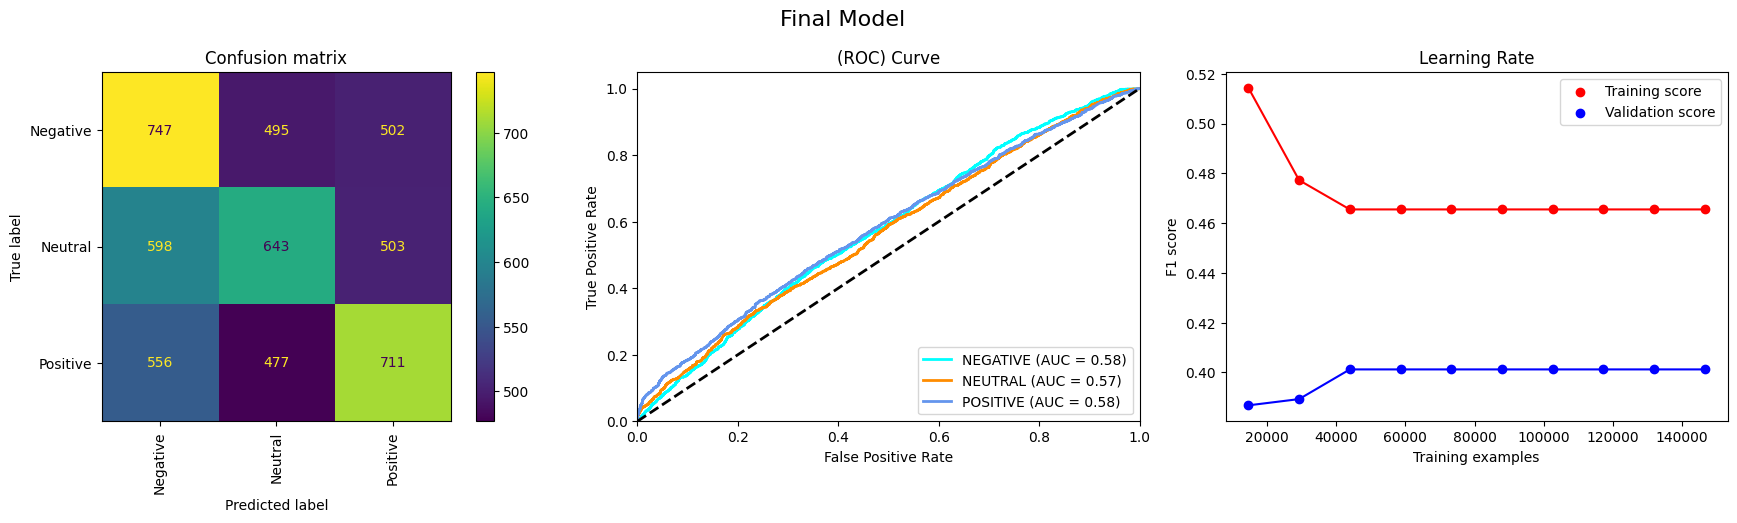

Final train score = 0.46550892810673333
Final val score = 0.40123708048894136


In [13]:
# using optuna I conclude that these are the final hyperparameters of my model
final_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df=0.9352543909806555, min_df=0.0007700183901679351)

# use a model with default hyperam
final_model = LogisticRegression(penalty='l2', C=0.26985593968549043, max_iter=20000, multi_class='multinomial', solver='lbfgs')
train_and_print_model(final_model, final_vectorizer, create_division_list(train_df.size, 10), conv_train_data, conv_test_data, "Final Model")

# **Final Submission**

In [14]:
test_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-1/test_set.csv") 
test_data = get_test_data(test_df)

In [15]:
trainn_x, trainn_y = conv_train_data
testt_x = test_data.to_numpy()

flattened_x = flatten_data(trainn_x)
flattened_y = flatten_data(trainn_y)
flattened_x_val = flatten_data(testt_x)

vec_train = final_vectorizer.fit_transform(flattened_x)

# train model
final_model.fit(vec_train, flattened_y)

temp_x_val = final_vectorizer.transform(flattened_x_val)

# make predictions using the test dataset
validation_pred = final_model.predict(temp_x_val)

df = pd.DataFrame({'Id': test_df['New_ID'], 'Predicted': validation_pred})
df.to_csv('output_file.csv', index=False)